In [2]:
from train_util import get_annotation

In [5]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
src_ap_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','ap','png_all')
# src_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','ap','png_16b_all')
annotations_ap_train_fn = "train_labeled_ap_metal.txt"
annotations_ap_test_fn = "test_labeled_ap_metal.txt"

In [4]:
import os
src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','png_all')
annotations_lat_train_fn = "train_labeled_lat_metal.txt"
annotations_lat_test_fn = "test_labeled_lat_metal.txt"

In [5]:
annotations_ap_test = get_annotation(src_ap_path, annotations_ap_test_fn)

Parsing annotation files


In [6]:
annotations_ap_train = get_annotation(src_ap_path, annotations_ap_train_fn)

Parsing annotation files


In [7]:
annotations_lat_train = get_annotation(src_lat_path, annotations_lat_train_fn)

Parsing annotation files


In [8]:
annotations_lat_test = get_annotation(src_lat_path, annotations_lat_test_fn)

Parsing annotation files


In [81]:
from detectron2.data import DatasetCatalog
DatasetCatalog.clear()

In [82]:
from detectron2.data import DatasetCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("knee_ap_" + d, lambda d=d:get_annotation(src_ap_path, d + '_labeled_ap_metal.txt'))
    

In [83]:
from detectron2.data import DatasetCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("knee_lat_" + d, lambda d=d:get_annotation(src_lat_path, d + '_labeled_lat_metal.txt'))
    

In [84]:
DatasetCatalog.list()

['knee_ap_train', 'knee_ap_test', 'knee_lat_train', 'knee_lat_test']

In [1]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("knee").thing_classes = ["knee", "Knee_with_implant"]
# MetadataCatalog.get("knee").thing_colors = [(255,48,48), (0,255,0)]

In [86]:
(cfg.MODEL.WEIGHTS)

'LAT_2020_04_14_10_15_54/model_final.pth'

In [90]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import time
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
# cfg.OUTPUT_DIR = 'AP_2020_04_10_12_00_00'
cfg.OUTPUT_DIR = 'LAT_2020_04_14_10_15_54'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set the testing threshold for this model
cfg.DATASETS.TEST = ("knee_ap_test")
# cfg.DATASETS.TEST = ("knee_lat_test")
predictor = DefaultPredictor(cfg)

(1458, 1376, 3)
Inference time is 0.106s
{'instances': Instances(num_instances=1, image_height=1458, image_width=1376, fields=[pred_boxes: Boxes(tensor([[ 327.7198,  403.4409, 1058.7257, 1044.1263]], device='cuda:0')), scores: tensor([0.9998], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


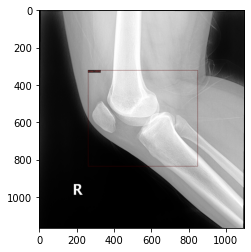

In [91]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
knee_ap_metadata = MetadataCatalog.get("knee")
# for d in random.sample(annotations_ap_train, 1):
for d in random.sample(annotations_lat_train, 1):    
    im = cv2.imread(d["file_name"], flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    # im = cv2.imread(d["file_name"]) # No tag will read the gray image as colored image BGR
    print(im.shape)
    start = time.time()
    outputs = predictor(im)
    print('Inference time is {:.3}s'.format(np.round(time.time() - start, 4)))
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print(outputs)
    # img_gt = v.draw_dataset_dict(d)   
    img_pred_gt = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(cv2.cvtColor(img_pred_gt.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

# Three fold cross-validation

In [3]:
import os
from detectron2.data import DatasetCatalog
src_ap_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','ap','png_all')
DatasetCatalog.clear()
for d in ["train", "test"]:
    for fold in range(1,4):
        DatasetCatalog.register("knee_ap_" + d + '_fold{}'.format(fold), lambda d=d:get_annotation(src_ap_path, d + '_labeled_ap_metal_fold{}.txt'.format(fold)))
DatasetCatalog.list()

In [12]:
from train_util import get_annotation
annotations_test = []
src_ap_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','ap','png_all')
output_dirs = ['AP_2020_04_20_15_14_38_fold1','AP_2020_04_20_16_56_18_fold2','AP_2020_04_20_18_37_03_fold3']
num_folds = len(output_dirs)
for i in range(num_folds):
    annotations_ap_test_fn = 'test_labeled_ap_metal_fold{}.txt'.format(i+1)
    annotations_test.append(get_annotation(src_ap_path, annotations_ap_test_fn))

Parsing annotation files
Parsing annotation files
Parsing annotation files


In [28]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
output_dirs = ['AP_2020_04_20_15_14_38_fold1','AP_2020_04_20_16_56_18_fold2','AP_2020_04_20_18_37_03_fold3']
# cfg.OUTPUT_DIR = 'AP_2020_04_10_12_00_00'
# for i in range(len(output_dirs)):
final_result_txt = 'test_predicted_ap_metal_April20.txt'
f_final = open(final_result_txt, 'w')
count = 0
for i in range(len(output_dirs)):
    cfg.OUTPUT_DIR = output_dirs[i]
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
    # cfg.DATASETS.TEST = ("knee_lat_test")
    predictor = DefaultPredictor(cfg)
    print('Working on fold{}:'.format(i+1))
    # output test result to txt file 
    result_txt = 'test_predicted_ap_metal_April20_fold{}.txt'.format(i+1)
    with open(result_txt, 'w') as f:
        # for d in random.sample(annotations_test, 1):
        for d in annotations_test[i]:
            count = count+1
            im = cv2.imread(d["file_name"])
            outputs = predictor(im)
            bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
            preds = outputs["instances"].pred_classes.to("cpu").numpy()
            if len(preds) > 1: # predicted two boxes
                preds_counter= Counter(preds)
                if preds_counter[0] == 1 and preds_counter[1] == 1:
                    pred_index = np.argmax(preds)
                    preds = preds[pred_index]
                    bbox = bbox[pred_index]
                else:
                    print('Error:' + d["file_name"])
                    continue
            [x1, y1, x2, y2] = bbox
            rowtxt = '{},{},{},{},{},{}'.format(d["image_id"], int(x1), int(y1), int(x2), int(y2), int(preds))
            print(str(count) + ": " + rowtxt)
            f.write(rowtxt)
            f.write('\n')
            f_final.write(rowtxt)
            f_final.write('\n')


f_final.close()

Working on fold1:
1: D1745477_R.png,294,533,1149,1526,0
2: D1745517_L.png,283,663,1413,1772,0
3: D1751214_R.png,222,531,1092,1565,0
4: D1801607_R.png,222,531,1092,1565,0
5: D1832380_L.png,187,470,986,1370,0
6: D1850955_L.png,187,470,986,1370,0
7: D1906166_L.png,266,522,1043,1467,0
8: D1981784_R.png,148,254,928,1193,0
9: D2033004_R.png,194,251,1102,1253,0
10: D2077551_R.png,116,428,1095,1554,0
11: D2154018_L.png,187,330,1096,1381,0
12: D2334725_R.png,178,363,1099,1421,0
13: D2408551_L.png,248,448,1103,1481,0
14: D2408551_R.png,169,445,1025,1414,0
15: D2411190_L.png,223,549,842,1266,0
16: D2411190_R.png,85,547,722,1247,0
17: D2633833_R.png,131,348,948,1280,0
18: D2643990_R.png,170,359,842,1103,0
19: D2644272_R.png,189,429,784,1083,0
20: D2659616_R.png,215,406,999,1111,0
21: D2690051_R.png,71,330,734,1155,0
22: D2692451_L.png,220,230,967,1066,0
23: D2692451_R.png,0,186,680,989,0
24: D2692639_L.png,186,387,815,1151,0
25: D2715314_L.png,205,266,781,974,0
26: D2727131_R.png,329,380,901,1167,

In [1]:
from train_util import iou,cal_iou_from_matched_file

for i in range(3):
    pred_file = "test_predicted_ap_metal_April20_fold{}.txt".format(i+1)
    gt_file = "test_labeled_ap_metal_fold{}.txt".format(i+1)
    result_AP = cal_iou_from_matched_file(gt_file, pred_file)

D3485160_R.png
IOU: 0.8341030163225095
ground_truth 1
predicted 0
mean IOU: 0.9315705012699121
Class accuracy: 0.9981060606060606
D3091984_L.png
IOU: 0.8421537583056479
ground_truth 1
predicted 0
D3578439_L.png
IOU: 0.9211238155296304
ground_truth 1
predicted 0
mean IOU: 0.9304492000766836
Class accuracy: 0.9962049335863378
W0573832_L.png
IOU: 0.8777543290393055
ground_truth 1
predicted 0
mean IOU: 0.9299187812703413
Class accuracy: 0.9981024667931688


In [2]:
# Verify on OAIbase
import os
oai_src_path = os.path.join('..','KneeQualityAssurance','data','OAIBase','knee_split_png')
img_list = os.listdir(oai_src_path)
print(len(img_list))

9014


In [3]:
#visually check some of the results
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

MetadataCatalog.get("knee").thing_classes = ["knee", "Knee_with_implant"]

cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
output_dirs = ['AP_2020_04_20_15_14_38_fold1','AP_2020_04_20_16_56_18_fold2','AP_2020_04_20_18_37_03_fold3']
knee_ap_metadata = MetadataCatalog.get("knee")
predictors = {}

for i in range(len(output_dirs)):
    cfg.OUTPUT_DIR = output_dirs[i]
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    predictor_name = 'predictor_fold{}'.format(i+1)
    predictors[predictor_name] = DefaultPredictor(cfg)   

In [4]:
colors = ['r', 'g', 'b']
color_dict = {key: colors[i] for i, key in enumerate(predictors.keys())} 
pred_dict = ['Knee', 'Knee with implant']

In [ ]:
import os
target_path = os.path.join('OAI_predictions')
for i, img_fn in enumerate(img_list):
# for img_fn in random.sample(img_list, 1):
    if not img_fn.endswith('.png'):
        continue
    img_path = os.path.join(oai_src_path, img_fn)
    im = cv2.imread(img_path)
    outputs = {}
    bboxes = []
    preds = []
    assigned_colors = []
    for p in predictors.keys():
        outputs[p] = predictors[p](im)
        bbox = outputs[p]["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        pred = outputs[p]["instances"].pred_classes.to("cpu").numpy()
        bboxes.append(bbox)
        preds.extend([str(i) for i in pred])
        assigned_colors.extend([color_dict[p] for i in range(len(outputs[p]["instances"]))])
    
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print('Processing image {}: {}'.format(i, img_fn))
    print(np.vstack(bboxes))
    print(preds)
    img_pred =  v.overlay_instances(boxes = np.vstack(bboxes),
                                      labels =preds,
                                      assigned_colors=assigned_colors)    
    # plt.imshow(img_pred.get_image())
    save_path = os.path.join(target_path, img_fn)
    cv2.imwrite(save_path, img_pred.get_image())

Processing image 0: 9990355_R.png
[[ 512.10254  535.151   1254.      1562.396  ]
 [ 515.54504  548.53937 1254.      1571.9165 ]
 [ 510.95117  544.5016  1254.      1577.8726 ]]
['0', '0', '0']
Processing image 1: 9088345_L.png
[[  75.79692  924.6871  1275.0035  2395.9858 ]
 [  79.28983  905.9224  1273.8347  2432.0312 ]
 [  75.16241  904.832   1274.5009  2443.3699 ]]
['0', '0', '0']
Processing image 2: 9900967_L.png
[[  24.71122   537.1865    699.7861   1246.976   ]
 [  38.319542  524.5974    695.70154  1270.8728  ]
 [  40.36591   531.1453    701.0017   1256.2485  ]]
['0', '0', '0']
Processing image 3: 9329345_R.png
[[ 355.0939   938.45953 1202.6914  1883.6819 ]
 [ 359.45267  910.2587  1214.8853  1903.3442 ]
 [ 359.14206  921.6804  1201.9275  1909.0175 ]]
['0', '0', '0']
Processing image 4: 9507791_L.png
[[   0.       470.7353   784.57214 1382.7261 ]
 [   0.       467.20334  794.8458  1384.7172 ]
 [   0.       465.83722  806.7891  1384.127  ]]
['0', '0', '0']
Processing image 5: 9739711_

In [9]:
import os
target_path = os.path.join('OAI_predictions')
for i, img_fn in enumerate(img_list, start=1562):
# for img_fn in random.sample(img_list, 1):
    if not img_fn.endswith('.png'):
        continue
    img_path = os.path.join(oai_src_path, img_fn)
    im = cv2.imread(img_path)
    outputs = {}
    bboxes = []
    preds = []
    assigned_colors = []
    for p in predictors.keys():
        outputs[p] = predictors[p](im)
        bbox = outputs[p]["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        pred = outputs[p]["instances"].pred_classes.to("cpu").numpy()
        bboxes.append(bbox)
        preds.extend([str(i) for i in pred])
        assigned_colors.extend([color_dict[p] for i in range(len(outputs[p]["instances"]))])
    
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print('Processing image {}: {}'.format(i, img_fn))
    print(np.vstack(bboxes))
    print(preds)
    img_pred =  v.overlay_instances(boxes = np.vstack(bboxes),
                                      labels =preds,
                                      assigned_colors=assigned_colors)    
    # plt.imshow(img_pred.get_image())
    save_path = os.path.join(target_path, img_fn)
    cv2.imwrite(save_path, img_pred.get_image())

Processing image 1562: 9990355_R.png
[[ 512.10254  535.151   1254.      1562.396  ]
 [ 515.54504  548.53937 1254.      1571.9165 ]
 [ 510.95117  544.5016  1254.      1577.8726 ]]
['0', '0', '0']
Processing image 1563: 9088345_L.png
[[  75.79692  924.6871  1275.0035  2395.9858 ]
 [  79.28983  905.9224  1273.8347  2432.0312 ]
 [  75.16241  904.832   1274.5009  2443.3699 ]]
['0', '0', '0']
Processing image 1564: 9900967_L.png
[[  24.71122   537.1865    699.7861   1246.976   ]
 [  38.319542  524.5974    695.70154  1270.8728  ]
 [  40.36591   531.1453    701.0017   1256.2485  ]]
['0', '0', '0']
Processing image 1565: 9329345_R.png
[[ 355.0939   938.45953 1202.6914  1883.6819 ]
 [ 359.45267  910.2587  1214.8853  1903.3442 ]
 [ 359.14206  921.6804  1201.9275  1909.0175 ]]
['0', '0', '0']
Processing image 1566: 9507791_L.png
[[   0.       470.7353   784.57214 1382.7261 ]
 [   0.       467.20334  794.8458  1384.7172 ]
 [   0.       465.83722  806.7891  1384.127  ]]
['0', '0', '0']
Processing im

In [8]:
img_list[1562]

'9190321_R.png'

In [76]:
np.hstack(preds)

array([0, 0, 0])

In [16]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
output_dirs = ['AP_2020_04_20_15_14_38_fold1','AP_2020_04_20_16_56_18_fold2','AP_2020_04_20_18_37_03_fold3']
# cfg.OUTPUT_DIR = 'AP_2020_04_10_12_00_00'
# for i in range(len(output_dirs)):
error_list = []
for i in range(len(output_dirs)):
    cfg.OUTPUT_DIR = output_dirs[i]
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
    # cfg.DATASETS.TEST = ("knee_lat_test")
    predictor = DefaultPredictor(cfg)
    result_txt = 'test_predicted_ap_oai_April20_fold{}.txt'.format(i+1)
    f = open(result_txt, 'w')
    print('Working on fold{}:'.format(i+1))
    count = 0
    for img_fn in img_list:
        if not img_fn.endswith('.png'):
            continue
        count = count+1
        img_path = os.path.join(oai_src_path, img_fn)
        im = cv2.imread(img_path)
#         im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
#         if len(im.shape) < 3:
#             im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
        outputs = predictor(im)   
        bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        preds = outputs["instances"].pred_classes.to("cpu").numpy()
        # TODO: filter boxes according to aspect ration
        
        if len(preds) > 1: # predicted two boxes
            preds_counter= Counter(preds)
            # TODO: finner suppression for duplicate box 
            if preds_counter[0] == 1 and preds_counter[1] == 1:
                pred_index = np.argmax(preds)
                preds = preds[pred_index]
                bbox = bbox[pred_index]
            else:
                print('Error:' + img_fn)
                error_list.append((img_fn, bbox, preds))
                continue
        [x1, y1, x2, y2] = bbox
        rowtxt = '{},{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2), int(preds))
        print(str(count) + ": " + rowtxt)    

        f.write(rowtxt)
        f.write('\n')
    
    f.close()


Working on fold1:
1: 9990355_R.png,512,535,1254,1562,0
2: 9088345_L.png,75,924,1275,2395,0
3: 9900967_L.png,24,537,699,1246,0
4: 9329345_R.png,355,938,1202,1883,0
5: 9507791_L.png,0,470,784,1382,0
6: 9739711_R.png,375,1451,1641,2944,0
7: 9941446_R.png,446,1036,1694,2421,0
8: 9968721_R.png,544,768,1806,2187,0
9: 9871347_L.png,113,776,1019,1792,0
10: 9670965_L.png,82,536,1023,1626,0
11: 9241014_L.png,142,452,1066,1450,0
12: 9246518_R.png,197,439,1088,1380,0
13: 9072281_L.png,122,563,786,1378,0
14: 9858840_L.png,177,511,943,1341,0
15: 9942867_L.png,163,740,962,1645,0
16: 9462298_R.png,334,583,1205,1627,0
17: 9200051_L.png,29,414,820,1359,0
18: 9259523_L.png,302,618,1194,1730,0
19: 9856356_L.png,222,394,1087,1330,0
20: 9478060_R.png,237,540,1044,1493,0
21: 9765203_R.png,239,719,986,1592,0
22: 9662427_L.png,201,680,1130,1735,0
23: 9189986_L.png,59,579,752,1388,0
24: 9865771_L.png,76,759,917,1751,0
25: 9896772_R.png,390,573,1087,1416,0
26: 9732751_R.png,495,646,1254,1673,0
27: 9084391_R.png,

In [17]:
error_list

[(array([[   0.     ,  302.6389 ,  889.0877 , 1450.074  ],
         [   0.     ,  328.9536 ,  469.75522, 1388.9752 ]], dtype=float32),
  array([0, 0])),
 (array([[ 163.82632 ,  769.76385 , 1122.807   , 1932.627   ],
         [  24.858051,   17.899292, 1254.      ,  478.85623 ]],
        dtype=float32), array([0, 0])),
 (array([[ 157.13536,  440.3195 ,  919.11316, 1388.8074 ],
         [ 323.8322 ,  451.80997,  845.8143 ,  773.4245 ]], dtype=float32),
  array([0, 0])),
 (array([[ 147.28232,  250.3852 ,  770.4248 , 1108.0234 ],
         [ 242.4823 ,  293.52606,  722.0333 ,  592.3503 ]], dtype=float32),
  array([1, 1])),
 (array([[  34.16671,  459.24634,  791.9653 , 1510.9204 ],
         [ 146.7493 ,  208.74284,  614.7428 ,  943.00836]], dtype=float32),
  array([0, 0])),
 (array([[  54.13381,  870.72766, 1087.     , 1604.356  ],
         [ 496.8655 ,  897.75   ,  985.27094, 1676.0933 ],
         [ 140.65672,  872.5511 ,  535.5388 , 1594.1122 ]], dtype=float32),
  array([0, 0, 0])),
 (arra

In [19]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import time
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = 'AP_2020_04_20_15_14_38_fold1'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [20]:
src_folder = os.path.join('..','KneeQualityAssurance','data','20200423_artifact')
img_list = os.listdir(src_folder)
num_imgs = len(img_list)

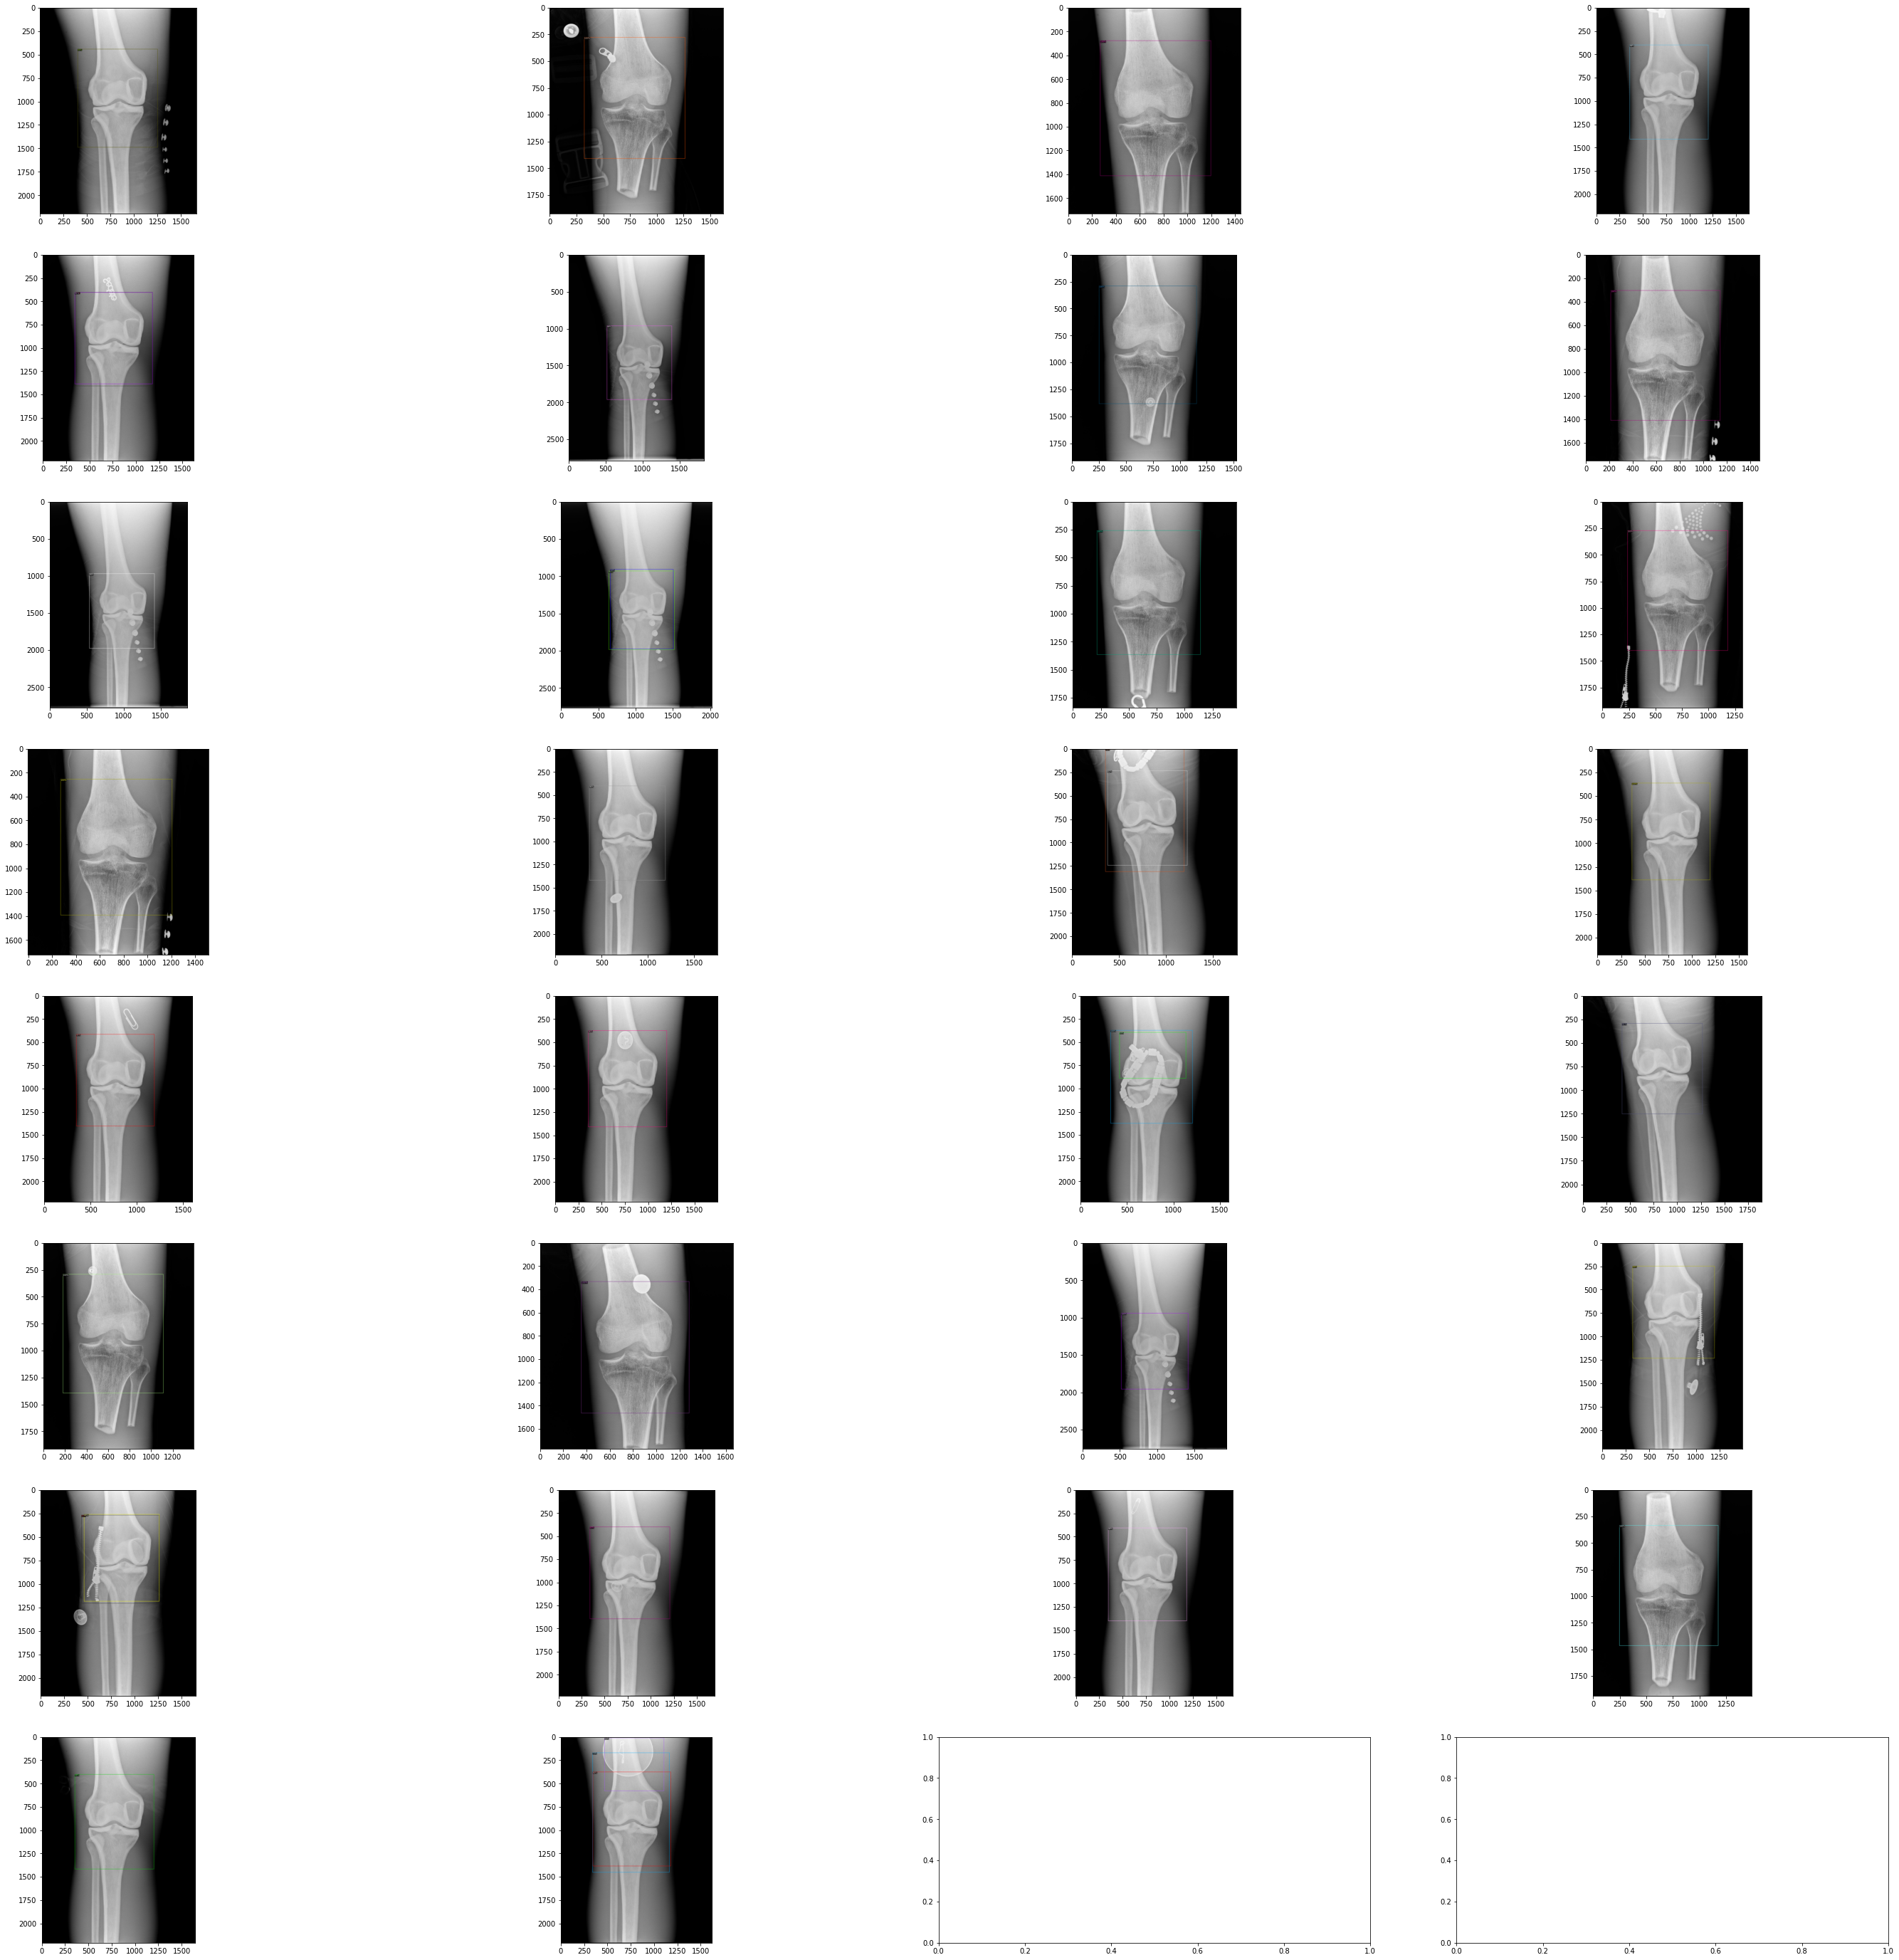

In [23]:
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
import math
%matplotlib inline
fig,axes = plt.subplots(nrows = math.ceil(num_imgs/4), ncols = 4, figsize=(50,50))
for i, img_fn in enumerate(img_list):
    img_path = os.path.join(src_folder, img_fn)
    im = cv2.imread(img_path)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
 
    v = Visualizer(im,
                   metadata=MetadataCatalog.get("knee_ap_train"), 
    )  
    # axes[i//4,i%4].imshow(im, cmap='bone')
    
    output = predictor(im)
    img_preds = v.draw_instance_predictions(output["instances"].to("cpu"))
    axes[i//4,i%4].imshow(img_preds.get_image(), cmap='bone')
    cv2.imwrite(os.path.join('Lab_April23_predictions',img_fn), img_preds.get_image())
#    axes[i//4,i%4].set_title('IOU: {:.3}'.format(cal_iou_from_bbox(gt_bbox,pred_bbox)))

In [17]:
output

{'instances': Instances(num_instances=1, image_height=2208, image_width=1622, fields=[pred_boxes: Boxes(tensor([[ 467.2601,   15.5824, 1101.5494,  581.5486]], device='cuda:0')), scores: tensor([0.9389], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}

In [18]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
output = predictor(im)
print(output)

{'instances': Instances(num_instances=3, image_height=2208, image_width=1622, fields=[pred_boxes: Boxes(tensor([[ 467.2601,   15.5824, 1101.5494,  581.5486],
        [ 341.7289,  379.6810, 1173.6991, 1385.5455],
        [ 339.2116,  174.6933, 1159.8352, 1452.1093]], device='cuda:0')), scores: tensor([0.9389, 0.7952, 0.7341], device='cuda:0'), pred_classes: tensor([1, 0, 1], device='cuda:0')])}


In [24]:
img_fn

'020FWQDQ_artifact_0.png'

In [10]:
import os
src_folder = os.path.join('..','KneeQualityAssurance','data','neg_all_may11','AP_png')
img_list = os.listdir(src_folder)
num_imgs = len(img_list)

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
output_dirs = ['AP_2020_05_06_18_25_35_fold1','AP_2020_05_06_20_07_44_fold2','AP_2020_05_06_21_50_10_fold3']
error_list = []
for i in range(len(output_dirs)):
    cfg.OUTPUT_DIR = output_dirs[i]
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
    # cfg.DATASETS.TEST = ("knee_lat_test")
    predictor = DefaultPredictor(cfg)
    result_txt = 'test_predicted_ap_neg_all_may11_fold{}.txt'.format(i+1)
    f = open(result_txt, 'w')
    print('Working on fold{}:'.format(i+1))
    count = 0
    for img_fn in img_list:
        if not img_fn.endswith('.png'):
            continue
        count = count+1
        img_path = os.path.join(src_folder, img_fn)
        im = cv2.imread(img_path)
        im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        if len(im.shape) < 3:
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
        outputs = predictor(im)   
        bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        preds = outputs["instances"].pred_classes.to("cpu").numpy()
        # TODO: filter boxes according to aspect ration
        
        [x1, y1, x2, y2] = bbox
        rowtxt = '{},{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2), int(preds))
        print(str(count) + ": " + rowtxt)    

        f.write(rowtxt)
        f.write('\n')
    
    f.close()


In [14]:
colors = ['r', 'g', 'b']
color_dict = {key: colors[i] for i, key in enumerate(predictors.keys())} 

In [17]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("knee").thing_classes = ["knee"]
knee_ap_metadata = MetadataCatalog.get("knee")

In [26]:
#visually check some of the results
import matplotlib.pyplot as plt
%matplotlib inline
import os
target_path = os.path.join('neg_all_may11_prediction')
# for i, img_fn in enumerate(img_list):
for img_fn in random.sample(img_list, 1):
    img_fn = 'D4018831_R.png'
    if not img_fn.endswith('.png'):
        continue
    img_path = os.path.join(src_folder, img_fn)
    im = cv2.imread(img_path)
    outputs = {}
    bboxes = []
    preds = []
    assigned_colors = []
    for p in predictors.keys():
        outputs[p] = predictors[p](im)
        bbox = outputs[p]["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        pred = outputs[p]["instances"].pred_classes.to("cpu").numpy()
        bboxes.append(bbox)
        preds.extend([str(i) for i in pred])
        assigned_colors.extend([color_dict[p] for i in range(len(outputs[p]["instances"]))])
        print(outputs[p])
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print('Processing image {}: {}'.format(i, img_fn))
    print(np.vstack(bboxes))
    print(preds)
    img_pred = v.overlay_instances(boxes=np.vstack(bboxes),
                                      labels=preds,
                                      assigned_colors=assigned_colors)    
    # plt.imshow(img_pred.get_image())
    save_path = os.path.join(target_path, img_fn)
    cv2.imwrite(save_path, img_pred.get_image())

{'instances': Instances(num_instances=1, image_height=1551, image_width=1160, fields=[pred_boxes: Boxes(tensor([[ 185.8567,  261.5307,  904.9763, 1163.3630]], device='cuda:0')), scores: tensor([0.9995], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}
{'instances': Instances(num_instances=1, image_height=1551, image_width=1160, fields=[pred_boxes: Boxes(tensor([[ 207.6431,  245.7319,  909.8210, 1150.0356]], device='cuda:0')), scores: tensor([0.9991], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=1551, image_width=1160, fields=[pred_boxes: Boxes(tensor([[ 141.7456,  257.4867,  924.4846, 1136.6105],
        [  45.9648,  323.7976,  469.4175,  902.2308]], device='cuda:0')), scores: tensor([0.9992, 0.8645], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}
Processing image 40: D4018831_R.png
[[ 185.85667   261.5307    904.97626  1163.363   ]
 [ 207.64314   245.7319    909.821    1150.0356

In [38]:
# Create a labeling file
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 
error_list = []
cfg.OUTPUT_DIR = 'AP_2020_05_06_21_50_10_fold3'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
# cfg.DATASETS.TEST = ("knee_lat_test")
predictor = DefaultPredictor(cfg)
result_txt = 'test_predicted_ap_neg_all_may11_fold{}.txt'.format(i+1)
f = open(result_txt, 'w')
print('Working on fold{}:'.format(i+1))
count = 0
for img_fn in img_list:
    if not img_fn.endswith('.png'):
        continue
    count = count+1
    img_path = os.path.join(src_folder, img_fn)
    im = cv2.imread(img_path)
    im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    outputs = predictor(im)     
    assert len(outputs) == 1, 'multiple box detected'
    bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
    preds = outputs["instances"].pred_classes.to("cpu").numpy()
    # TODO: filter boxes according to aspect ration
    
    
    [x1, y1, x2, y2] = bbox
    rowtxt = '{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2))
    print(str(count) + ": " + rowtxt)    

    f.write(rowtxt)
    f.write('\n')

f.close()


Working on fold41:
1: D1977262_R.png,300,417,1270,1443
2: W0294975_L.png,199,468,1048,1415
3: W0544635_L.png,287,906,1219,1960
4: D4028846_R.png,238,345,847,1072
5: D2144214_R.png,345,683,1308,1889
6: D4018831_R.png,141,257,924,1136
7: D2017870_L.png,241,716,1081,1650
8: D3911834a_L.png,331,383,988,1091
9: D3933031_R.png,172,336,831,1086
10: D2133141_L.png,372,401,1284,1393
11: W0544635_R.png,279,885,1234,1935
12: D2096892_L.png,245,1672,1255,2914
13: D4028369_R.png,268,359,892,1050
14: D2155016_R.png,233,429,1221,1416
15: D3923237_L.png,319,252,1060,1101
16: D3922871a_R.png,340,324,983,1088
17: W0294120_R.png,170,546,1075,1497
18: D3957489_L.png,155,434,747,1112
19: D3923237a_L.png,186,276,944,1070
20: D2037560_L.png,327,423,1175,1349
21: D2106369_L.png,285,597,1177,1644
22: D2065519_L.png,212,563,1022,1443
23: D3957489_R.png,311,454,904,1165
24: D2122476_R.png,381,428,1197,1362
25: D3933031a_R.png,233,420,893,1168
26: D3957489b_R.png,236,389,854,1074
27: D3910639a_R.png,305,353,927,1

In [35]:
len(outputs['predictor_fold1'])

1

In [1]:
import os
src_folder = os.path.join('..','KneeQualityAssurance','data','neg_all_may11','LAT_png')
img_list = os.listdir(src_folder)
num_imgs = len(img_list)

In [4]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
from detectron2.utils.visualizer import Visualizer
import random
import numpy as np
from collections import Counter
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
MetadataCatalog.get("knee").thing_classes = ["knee"]
knee_ap_metadata = MetadataCatalog.get("knee")
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')

cfg.OUTPUT_DIR = 'LAT_2020_04_14_10_15_54'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
result_txt = 'test_predicted_lat_neg_all_may11.txt'
target_path = os.path.join('neg_all_may11_lat_prediction')
predictor = DefaultPredictor(cfg)
f = open(result_txt, 'w')
count = 0
for img_fn in img_list:
# for img_fn in random.sample(img_list, 1):
    if not img_fn.endswith('.png'):
        continue
    img_path = os.path.join(src_folder, img_fn)
    im = cv2.imread(img_path)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    count += 1
    outputs= predictor(im)
    bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
    preds = outputs["instances"].pred_classes.to("cpu").numpy()
    
    if len(preds) > 1: # predicted two boxes
        preds_counter=Counter(preds)
        if preds_counter[0] == 1 and preds_counter[1] == 1:
            pred_index = np.argmin(preds)
            preds = preds[pred_index]
            bbox = bbox[pred_index]
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print('Processing image {}'.format(img_fn))
    img_pred = v.overlay_instances(boxes=[bbox], labels=[preds])    
    save_path = os.path.join(target_path, img_fn)
    # plt.imshow(img_pred.get_image())
    # cv2.imwrite(save_path, img_pred.get_image())
    [x1, y1, x2, y2] = bbox
    rowtxt = '{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2))
    print(str(count) + ": " + rowtxt)    

    f.write(rowtxt)
    f.write('\n')
f.close()

Processing image W0294635_R.png
1: W0294635_R.png,161,619,1017,1452
Processing image D4021619_R.png
2: D4021619_R.png,269,474,1037,1092
Processing image D2017888_R.png
3: D2017888_R.png,211,1015,1306,2015
Processing image D4020270_L.png
4: D4020270_L.png,314,373,1098,1068
Processing image D4015878_R.png
5: D4015878_R.png,118,481,773,1099
Processing image W0294042_R.png
6: W0294042_R.png,210,452,1156,1368
Processing image D2060718_L.png
7: D2060718_L.png,509,565,1530,1535
Processing image W0354036_L.png
8: W0354036_L.png,289,429,1059,1256
Processing image D2060718_R.png
9: D2060718_R.png,253,650,1259,1583
Processing image D4022920_R.png
10: D4022920_R.png,220,356,940,1024
Processing image D4020702_R.png
11: D4020702_R.png,203,548,908,1248
Processing image D2199446_L.png
12: D2199446_L.png,447,807,1286,1797
Processing image D4016351_R.png
13: D4016351_R.png,209,437,1021,1113
Processing image D3933031_R.png
14: D3933031_R.png,369,468,1049,1086
Processing image D4028412_L.png
15: D4028412_

In [26]:
f.close()

NameError: name 'f' is not defined

In [14]:
np.argmin

<function numpy.argmin(a, axis=None, out=None)>

In [38]:
# Create a labeling file
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 
error_list = []
cfg.OUTPUT_DIR = 'AP_2020_05_06_21_50_10_fold3'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
# cfg.DATASETS.TEST = ("knee_lat_test")
predictor = DefaultPredictor(cfg)
result_txt = 'test_predicted_ap_neg_all_may11_fold{}.txt'.format(i+1)
f = open(result_txt, 'w')
print('Working on fold{}:'.format(i+1))
count = 0
for img_fn in img_list:
    if not img_fn.endswith('.png'):
        continue
    count = count+1
    img_path = os.path.join(src_folder, img_fn)
    im = cv2.imread(img_path)
    im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    outputs = predictor(im)     
    assert len(outputs) == 1, 'multiple box detected'
    bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
    preds = outputs["instances"].pred_classes.to("cpu").numpy()
    # TODO: filter boxes according to aspect ration
    
    
    [x1, y1, x2, y2] = bbox
    rowtxt = '{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2))
    print(str(count) + ": " + rowtxt)    

    f.write(rowtxt)
    f.write('\n')

f.close()


Working on fold41:
1: D1977262_R.png,300,417,1270,1443
2: W0294975_L.png,199,468,1048,1415
3: W0544635_L.png,287,906,1219,1960
4: D4028846_R.png,238,345,847,1072
5: D2144214_R.png,345,683,1308,1889
6: D4018831_R.png,141,257,924,1136
7: D2017870_L.png,241,716,1081,1650
8: D3911834a_L.png,331,383,988,1091
9: D3933031_R.png,172,336,831,1086
10: D2133141_L.png,372,401,1284,1393
11: W0544635_R.png,279,885,1234,1935
12: D2096892_L.png,245,1672,1255,2914
13: D4028369_R.png,268,359,892,1050
14: D2155016_R.png,233,429,1221,1416
15: D3923237_L.png,319,252,1060,1101
16: D3922871a_R.png,340,324,983,1088
17: W0294120_R.png,170,546,1075,1497
18: D3957489_L.png,155,434,747,1112
19: D3923237a_L.png,186,276,944,1070
20: D2037560_L.png,327,423,1175,1349
21: D2106369_L.png,285,597,1177,1644
22: D2065519_L.png,212,563,1022,1443
23: D3957489_R.png,311,454,904,1165
24: D2122476_R.png,381,428,1197,1362
25: D3933031a_R.png,233,420,893,1168
26: D3957489b_R.png,236,389,854,1074
27: D3910639a_R.png,305,353,927,1